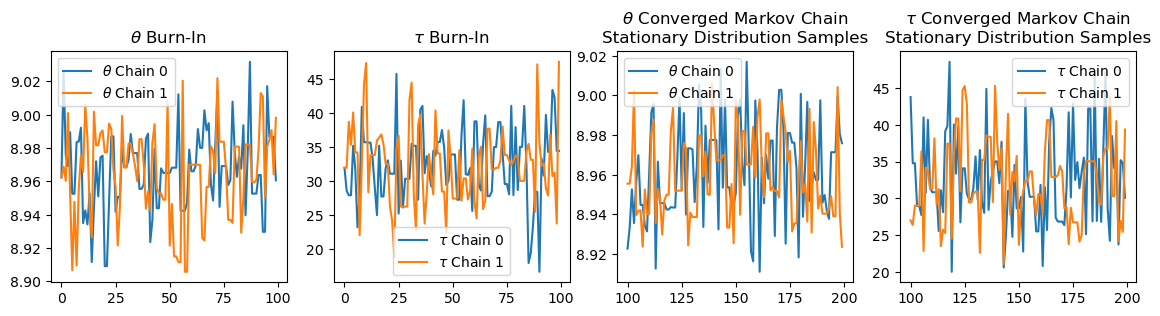

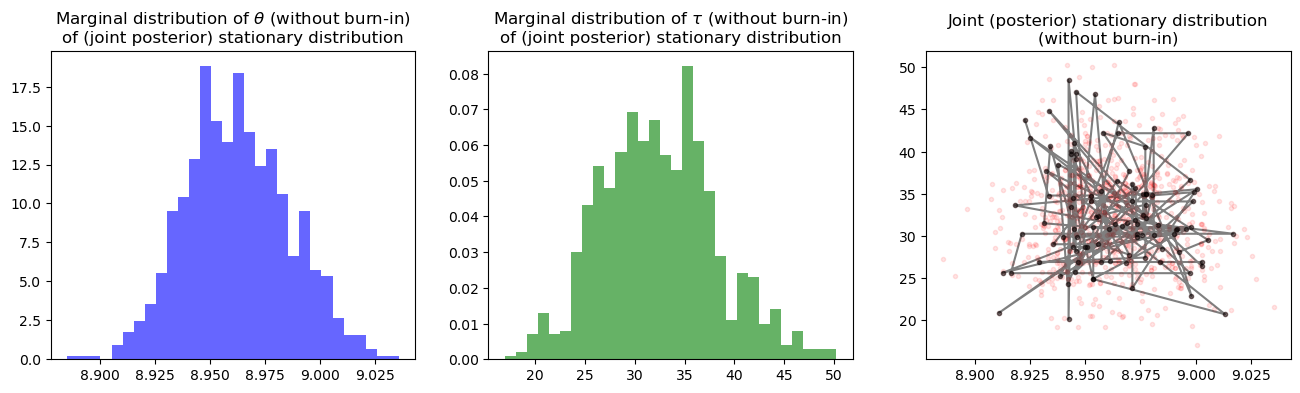

In [1]:
#Q1
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

n = 30 
m = 9   
s = 0.2 
x = stats.norm(loc=m, scale=s).rvs(size=n)  

C = 2       
G = 1000   
theta = np.zeros([C, G]) 
tau = np.zeros([C, G])    


theta[:, 0] = x.mean()  
tau[:, 0] = 1 / x.var() 

for c in range(C):
    for g in range(1, G):
        tau_proposal = stats.gamma(a=n/2 + 1, scale=2/sum((x - theta[c, g - 1])**2)).rvs(1)
        
        if tau_proposal > 0:  
            ratio_tau = stats.gamma(a=n/2 + 1, scale=2/sum((x - theta[c, g - 1])**2)).pdf(tau_proposal) / \
                        stats.gamma(a=n/2 + 1, scale=2/sum((x - theta[c, g - 1])**2)).pdf(tau[c, g - 1])
            accept_tau = min(1, ratio_tau)
            if np.random.rand() < accept_tau:
                tau[c, g] = tau_proposal
            else:
                tau[c, g] = tau[c, g - 1]
        
        theta_proposal = stats.norm(loc=x.mean(), scale=1/(n * tau[c, g])**0.5).rvs(1)
        
        ratio_theta = stats.norm(loc=x.mean(), scale=1/(n * tau[c, g])**0.5).pdf(theta_proposal) / \
                      stats.norm(loc=x.mean(), scale=1/(n * tau[c, g - 1])**0.5).pdf(theta[c, g - 1])
        accept_theta = min(1, ratio_theta)
        if np.random.rand() < accept_theta:
            theta[c, g] = theta_proposal
        else:
            theta[c, g] = theta[c, g - 1]


burn = 100  
demo = 200  

fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

for c in range(C):
    ax[0].plot(theta[c, :burn], label="$\\theta$ Chain " + str(c))
    ax[1].plot(tau[c, :burn], label="$\\tau$ Chain " + str(c))
    ax[2].plot(np.arange(burn, demo), theta[c, burn:demo], label="$\\theta$ Chain " + str(c))
    ax[3].plot(np.arange(burn, demo), tau[c, burn:demo], label="$\\tau$ Chain " + str(c))

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0, burn:], bins=30, density=True, alpha=0.6, color='blue')
ax[1].hist(tau[0, burn:], bins=30, density=True, alpha=0.6, color='green')
ax[2].plot(theta[0, burn:], tau[0, burn:], '.', alpha=0.1, color='red')


demo_samples = 100
ax[2].plot(theta[0, burn:burn + demo_samples], tau[0, burn:burn + demo_samples], '.-', color='black', alpha=0.5)

plt.show()

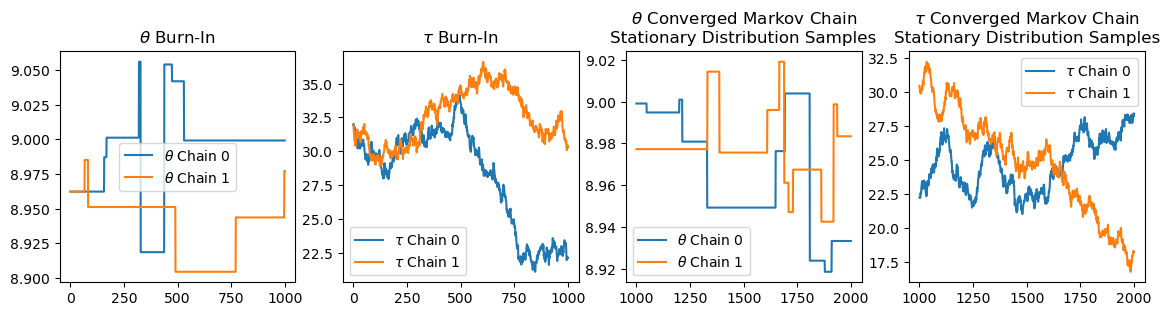

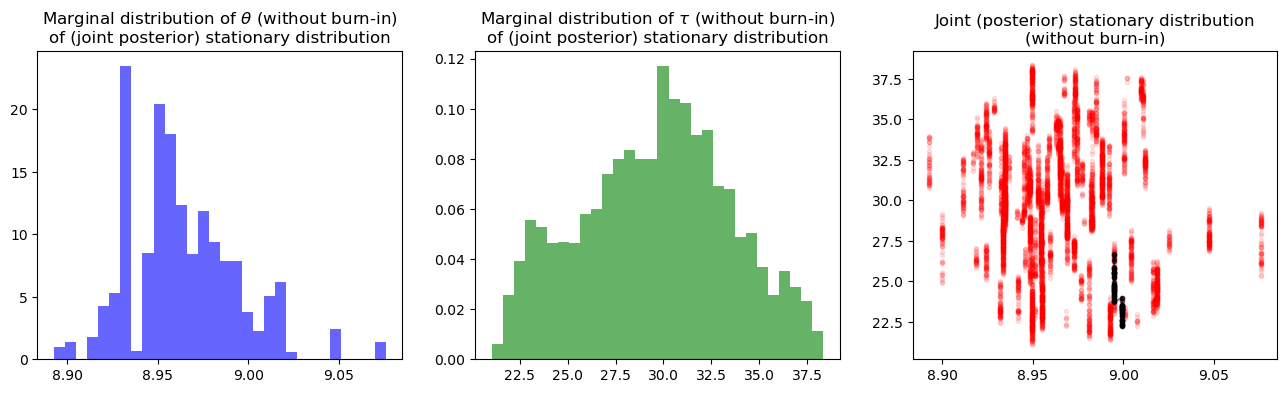

In [6]:
#Q2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


n = 30
s = 0.2
x = stats.norm(loc=0, scale=1).rvs(size=n)

C, G = 2, 10000  
theta, tau = np.zeros([C, G]), np.zeros([C, G])
theta[:, 0] = 1000  
tau[:, 0] = 1.0

burn = 20  
demo = 120  


for c in range(C):
    for g in range(1, G):

        tau_t_minus_1 = tau[c, g - 1]
        tau_proposal = stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf, loc=tau_t_minus_1, scale=s).rvs(1)

        if tau_proposal > 0:
            ratio_tau = (stats.gamma(a=n/2 + 1, scale=2/sum((x - theta[c, g - 1])**2)).pdf(tau_proposal) /
                         stats.gamma(a=n/2 + 1, scale=2/sum((x - theta[c, g - 1])**2)).pdf(tau[c, g - 1]))
            accept_tau = min(1, ratio_tau)
            if np.random.rand() < accept_tau:
                tau[c, g] = tau_proposal
            else:
                tau[c, g] = tau[c, g - 1]

        theta_proposal = stats.gamma(a=2, scale=5).rvs(1)  # Non-normal prior for theta (Gamma distribution)

        # Step 4: Calculate acceptance probability for theta
        denom_theta = 1/(n*tau[c, g])**0.5
        denom_prev_theta = 1/(n*tau[c, g - 1])**0.5
        ratio_theta = stats.norm(x.mean(), denom_theta).pdf(theta_proposal) / stats.norm(x.mean(), denom_prev_theta).pdf(theta[c, g - 1])
        accept_theta = min(1, ratio_theta)
        if np.random.rand() < accept_theta:
            theta[c, g] = theta_proposal
        else:
            theta[c, g] = theta[c, g - 1]


fig, ax = plt.subplots(1, 3, figsize=(16, 4))


ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[0].hist(theta[0, burn:], bins=30, alpha=0.7)


ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].hist(tau[0, burn:], bins=30, alpha=0.7)


ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")
ax[2].plot(theta[0, burn:], tau[0, burn:], '.', alpha=0.1)
ax[2].plot(theta[0, burn:demo], tau[0, burn:demo], color="orange")

plt.tight_layout()
plt.show()

#Q3
We want prove the transition kernel K of transition probabilities in the Metropolis-Hastings algorithm
we first given a Metropolis-Hastings target distribution p, based on a proposal distribution q, we need to show how the proposal distribution combines with the acceptance probability to form the transition kernel K, which is used for sampling from the target distribution.
![](target.png)
Step 1: Calculate the Transition Kernel 
![](K.png)
Step 2: Calculate Each Probability
![](eachp.png)

Step 3: Fill in the Transition Kernel 

![](fill.png)

In this way, we know transition kernel K means if the current state is 0, there is a 50% chance it will stay as 0, and a 50% chance it will change to 1. If the current state is 1, there is a 75% chance it will stay as 1, and a 25% chance it will change to 0. This indicates geometric distributions with expected values of 1 and 3 "failures before transitioning to the other state," meaning that on average, a "0 state" will be a run of two 0's, while a "1 state" will be a run of four 1's.

Text(0.5, 1.0, '1 run lengths, average: 4.301')

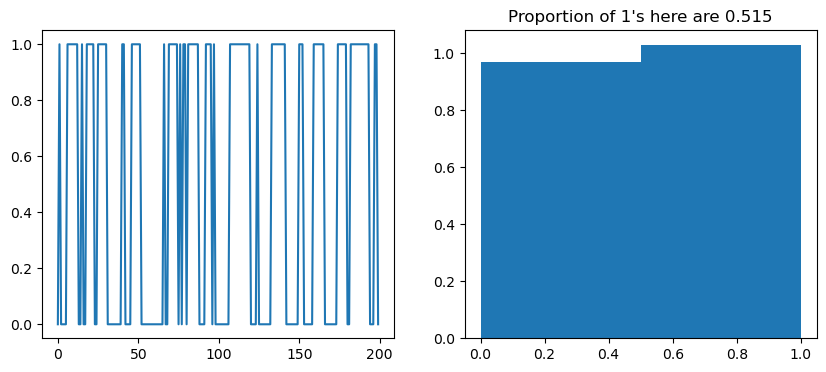

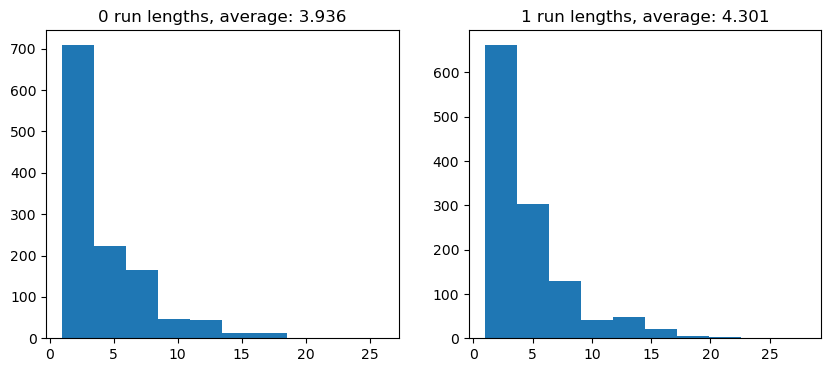

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

K = np.array([[0.5, 0.25], [0.5, 0.75]])  # Transition kernel

# Simulate 200 steps using the transition probabilities defined by K
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[s_t[t-1], 1])

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are " + str(s_t.mean()))

# Simulate for 10,000 steps
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[s_t[t-1], 1])

# Calculate the run lengths for 0's and 1's
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1, T):
    if s_t[t] == s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length.append(run_length)
        else:
            state1_run_length.append(run_length)
        run_length = 1

# Plot the run lengths
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths, average: " + str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths, average: " + str(np.mean(state1_run_length).round(3)))